<a href="https://colab.research.google.com/github/brunoodon/mvp-sprint1/blob/main/MVP_Sprint1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MVP - Sprint I - Análise de Dados e Boas Práticas**


## **Definição do problema**

É um problema de **aprendizado supervisionado**, onde o objetivo final será determinar quais departamentos e ativos da empresa "Fake Company" merecem mais atenção em relação às vulnerabilidades encontradas nos alertas.

Para a realização deste MVP serão utilizados 3 datasets: os 2 primeiros servirão apenas para correlação de dados e criação dos alertas, que estarão no 3º dataset (que será o produto).

Descrição de cada dataset:

*assets.csv:* o inventário atualizado de ativos da empresa;

*known_exploited_vulnerabilities.csv*: dataset do CISA que contém as vulnerabilidades recém exploradas ao redor do mundo.

Uma **restrição** encontrada no dataset acima foi a falta do campo **Severity Score** de cada vulnerabilidade em questão. Essa informação é essencial para tomada de decisão em relação à priorização ou não do tratamento da vulnerabilidade encontrada, por este motivo, essa informação será complementada com a consulta ao banco de NVD, que tem todas as informações pertinentes a cada vulnerabilidade publicada;

*vulnerabilty_alerts.csv:* alertas de vulnerabilidades presentes nos ativos do inventário.



### **Explicando o dataset vulnerability_alerts**

Contém os alertas gerados da correlação entre o inventário de ativos do cliente e a base de dados de vulnerabilidades exploradas.

**Atributos:**

Vulnerability: CVE ID da vulnerabilidade encontrada;

SeverityScore: indicador (de 0 a 10) que define a criticidade da vulnerabilidade;

VulnerabilityName: nome da vulnerabilidade;

AlertDate: data em que a vulnerabilidade foi encontrada no ativo;

Application: nome da aplicação vulnerável;

Department: departamento onde o ativo está localizado;

Description: descrição da vulnerabilidade;

ExploitationVector: vetor de exploração da vulnerabilidade;

Hostname: hostname do ativo;

IP: endereço IP do ativo;

Vendor: fabricante do software vulnerável.


### **Dataset de ativos**

Neste bloco da aplicação, estão sendo importadas as bibliotecas necessárias para a execução das tarefas.

O dataset assets.csv contém dados fictícios sobre ativos da empresa "Fake Company".



In [70]:
import pandas as pd
import requests
import numpy as np
import csv
import json
import datetime
import time
import statistics
#url do dataset de ativos da empresa
url_inventory = 'https://raw.githubusercontent.com/brunoodon/mvp-sprint1/main/assets.csv'
#lendo e dando 'print' no dataset para análise dos campos e registros
inventory = pd.read_csv(url_inventory)
display(inventory)

,application,ip,hostname,dep
0,Exchange Server,172.16.0.20,mail.fakecomp.com,TI
1,iOS,10.0.0.200,fake-cellphone,Vendas
2,Windows,10.0.0.150,desktop01,Vendas
3,Chromium,10.0.0.150,desktop01,Vendas
4,Firefox,10.0.0.150,desktop01,Vendas
...,...,...,...,...
58,Pulse Connect Secure,10.30.2.1,vpn-srv,TI
59,Pulse Connect Secure,10.30.2.1,vpn-srv,TI
60,Pulse Connect Secure,10.30.2.1,vpn-srv,TI
61,Pulse Connect Secure,10.30.2.1,vpn-srv,TI


### **Dataset de vulnerabilidades exploradas**
Neste bloco, está sendo feito o acesso e a leitura e o print do dataset known_exploited_vulnerabilities.csv, retirado do site do CISA.

In [71]:
#url do dataset de vulnerabilidades recentemente exploradas
url_cve = 'https://raw.githubusercontent.com/brunoodon/mvp-sprint1/main/known_exploited_vulnerabilities.csv'
#lendo e dando 'print' no dataset para análise dos campos e registros
exploited_cve = pd.read_csv(url_cve)
display(exploited_cve)

,CVE ID,Vendor Project,Product,Vulnerability Name,Date Added,Short Description,Required Action,Due Date,Notes
0,CVE-2022-42827,Apple,iOS and iPadOS,Apple iOS and iPadOS Out-of-Bounds Write Vulne...,10/25/2022,Apple iOS and iPadOS kernel contain an out-of-...,Apply updates per vendor instructions.,11/15/2022,https://support.apple.com/en-us/HT213489
1,CVE-2022-41352,Zimbra,Collaboration (ZCS),Zimbra Collaboration (ZCS) Arbitrary File Uplo...,10/20/2022,Zimbra Collaboration (ZCS) allows an attacker ...,Apply updates per vendor instructions.,11/10/2022,https://wiki.zimbra.com/wiki/Security_Center
2,CVE-2022-41082,Microsoft,Exchange Server,Microsoft Exchange Server Remote Code Executio...,9/30/2022,Microsoft Exchange Server contains an unspecif...,Apply updates per vendor instructions.,10/21/2022,https://msrc-blog.microsoft.com/2022/09/29/cus...
3,CVE-2022-41040,Microsoft,Exchange Server,Microsoft Exchange Server Server-Side Request ...,9/30/2022,Microsoft Exchange Server allows for server-si...,Apply updates per vendor instructions.,10/21/2022,https://msrc-blog.microsoft.com/2022/09/29/cus...
4,CVE-2022-41033,Microsoft,Windows COM+ Event System Service,Microsoft Windows COM+ Event System Service Pr...,10/11/2022,Microsoft Windows COM+ Event System Service co...,Apply updates per vendor instructions.,11/1/2022,https://msrc.microsoft.com/update-guide/en-US/...
...,...,...,...,...,...,...,...,...,...
844,CVE-2006-2492,Microsoft,Word,Microsoft Word Malformed Object Pointer Vulner...,6/8/2022,Microsoft Word and Microsoft Works Suites cont...,Apply updates per vendor instructions.,6/22/2022,NaN
845,CVE-2006-1547,Apache,Struts 1,Apache Struts 1 ActionForm Denial-of-Service V...,1/21/2022,ActionForm in Apache Struts versions before 1....,Apply updates per vendor instructions.,7/21/2022,NaN
846,CVE-2005-2773,Hewlett Packard (HP),OpenView Network Node Manager,HP OpenView Network Node Manager Remote Code E...,3/25/2022,HP OpenView Network Node Manager could allow a...,Apply updates per vendor instructions.,4/15/2022,NaN
847,CVE-2004-0210,Microsoft,Windows,Microsoft Windows Privilege Escalation Vulnera...,3/3/2022,A privilege elevation vulnerability exists in ...,Apply updates per vendor instructions.,3/24/2022,NaN


### **Enriquecimento do dataset**

Neste bloco, a aplicação fará:

*   O enriquecimento do dataset de vulnerabilidades exploradas. O SeverityScore e o ExploitationVector serão obtidos via query no banco NVD, que contém todas as vulnerabilidades registradas;
*   O correlacionamento de informações de inventário com as vulnerabilidades exploradas.
*   A consolidação dessas informações e o envio para um Data Warehouse com Elasticsearch e Kibana, para melhor análise;
*   A criação do dataset de alertas, que será trabalhado adiante. Primeiramente, ele será armazenado em documentos JSON, dentro do cluster de Elasticseach, para adiante (nas fases de análise e pré-processamento) ser convertido para CSV.






In [ ]:
from pandas.io.parsers import python_parser
#percorrendo cada linha do dataset de inventário de ativos do cliente
for a in range(len(inventory)):
  application=inventory.values[a][0]
  ip=inventory.values[a][1]
  hostname=inventory.values[a][2]
  dep=inventory.values[a][3]
  #criando uma variável com a data atual, a ser atribuída como data do alerta
  today=str(datetime.date.today())
  #fazendo a busca dos registros do dataset de vulnerabilidades exploradas onde o campo 'Product' contém o nome da aplicação descrita em cada linha de inventário 
  search = exploited_cve.query('Product.str.contains("'+application+'") == True', engine="python")
  #percorrendo cada resultado dessa busca e atribuíndo os valores às variáveis
  for b in range(len(search)):
      cve=search.values[b][0]
      vendor=search.values[b][1]
      product=search.values[b][2]
      vulnerability_name=search.values[b][3]
      date_added=search.values[b][4]
      short_desc=search.values[b][5]
      due_date=search.values[b][6]
      notes=search.values[b][7]
      #fazendo a consulta do CVE no banco do NVD, para enriquecer o dataset 
      url_nvd = 'https://services.nvd.nist.gov/rest/json/cves/2.0?cveId='+cve+''
      r_nvd = requests.get(url_nvd)
      try:
        #lendo o json com o resultado e atribuindo cada resultado de campo às varáveis severity_score e vector_string
        #obs: foi preciso estabelecer 2 possíveis estruturas, uma para cada versão da métrica de severity score (V2 ou V3.1)
        json_nvd = json.loads(r_nvd.text)
        for c in json_nvd['vulnerabilities']:
          try:
            for d in c['cve']['metrics']['cvssMetricV31']:
              vector_string = d['cvssData']['vectorString']
              #convertendo o campo de severity_score em float
              severity_score = float(d['cvssData']['baseScore'])
          except:
            for d in c['cve']['metrics']['cvssMetricV2']:
              vector_string = d['cvssData']['vectorString']
              severity_score = float(d['cvssData']['baseScore'])
          #foi necessário um temporizador porque a API do NVD tem limitação de requests por minuto
          time.sleep(8)
        #os dados correlacionados são inseridos como documentos JSON no índice alerts, no Elastisearch. Este é o dataset que será analisado e tratado
        es_url = 'http://mvp-puc.brunoodon.com.br:9200/alerts/_doc'
        es_header = {'Content-Type': 'application/json'}
        es_json = {
        'Vulnerability': cve,
        'VulnerabilityName': vulnerability_name,
        'Description': short_desc,
        'IP': ip,
        'Vendor': vendor,
        'Hostname': hostname,
        'Application': application,
        'ExploitationVector': vector_string,
        'SeverityScore': float(severity_score),
        'AlertDate': today,
        'Department': dep
        }
        r_es = requests.post(es_url, headers=es_header, verify=False, json=es_json)
        print(cve, vulnerability_name, short_desc, ip, vendor, hostname, application, vector_string, severity_score, today, dep)
      except:
        print('Nenhuma vulnerabilidade encontrada no ativo')


## **Análise de dados**

### **Métricas**

No bloco abaixo, serão aplicadas as métricas de média, mediana e moda no severity score, com o intuito de mensurar a situação de cada departamento em relação às vulnerabilidades encontradas.

In [87]:
#capturando, do dataset, de inventário, todos os departamentos existentes e os inserindo em uma lista sem registros repetidos:
assets_df = pd.read_csv(url_inventory)['dep']
deps=[]
for l in assets_df:
  if not l in deps:
    deps.append(l)
print(deps)
#url  e cabeçalho da API do Elasticsearch
es_url = 'http://mvp-puc.brunoodon.com.br:9200/alerts/_search'
es_header = {'Content-Type': 'application/json'}
#criação da função es_search, que vai executar todas as linhas de código abaixo para cada departamento encontrado
def es_search():
  es_query = json.dumps({
    "query": {
        "match":
  {
    "Department": i
  }    }
  })
  #executando a busca no Elasticsearch
  search_es = requests.post(es_url, headers=es_header, data=es_query)
  result_es = json.loads(search_es.text)
  #criando uma lista de severity scores para cada departamento para que sejam calculadas a média, a mediana e a moda desses valores.
  severity_score_list=[]
  for a in result_es['hits']['hits']:
    severity_score = float(a['_source']['SeverityScore'])
    severity_score_list.append(severity_score)
  array = np.array(severity_score_list)
  #caluculando mediana, média e moda dos valores contidos no array de severity scores
  median = np.median(array)
  avg = np.average(array)
  mode = statistics.mode(array)
  #exibindo os resultados
  print('Department:', i)
  print(severity_score_list)
  print('Severity Score Average is:', float(avg))
  print('Severity Score Median is:', float(median))
  print('Severity Score Mode is:', float(mode))
  print('##################')
  today=str(datetime.date.today())
  #inserindo os valores como documentos do índice indicators, no Elasticsearch, para que os gráficos possam ser criados no Kibana
  es_url_ind = 'http://mvp-puc.brunoodon.com.br:9200/indicators/_doc'
  es_json = {
      'Department': i,
      'SeverityScoreAVG': float(avg),
      'SeverityScoreMedian': float(median),
      'SeverityScoreMode': float(mode),
      'Date': today

      }
  r_es = requests.post(es_url_ind, headers=es_header, verify=False, json=es_json)

for i in deps:
  es_search()

['TI', 'Vendas', 'Laboratório', 'Segurança Cibernética', 'Desenvolvimento', 'RH']
Department: TI
[8.8, 8.8, 8.8, 9.8, 9.8, 7.5, 7.2, 8.8, 8.8, 9.8]
Severity Score Average is: 8.809999999999999
Severity Score Median is: 8.8
Severity Score Mode is: 8.8
##################
Department: Vendas
[7.8, 7.8, 7.8, 8.8, 9.8, 3.3, 7.5, 7.8, 7.8, 7.8]
Severity Score Average is: 7.62
Severity Score Median is: 7.8
Severity Score Mode is: 7.8
##################
Department: Laboratório
[7.5, 6.5, 8.8, 6.5, 8.8, 9.6, 9.6, 8.8, 8.8, 8.8]
Severity Score Average is: 8.37
Severity Score Median is: 8.8
Severity Score Mode is: 8.8
##################
Department: Segurança Cibernética
[9.8, 10.0, 5.3, 9.8, 9.8, 5.3, 9.8, 9.8]
Severity Score Average is: 8.700000000000001
Severity Score Median is: 9.8
Severity Score Mode is: 9.8
##################
Department: Desenvolvimento
[8.8, 9.8, 7.5, 7.5, 5.0, 10.0, 10.0, 4.3, 5.0, 10.0]
Severity Score Average is: 7.790000000000001
Severity Score Median is: 8.15
Severity Sc

### **Analisando o dataset vulnerability_alerts**

Fruto da correlação dos datasets anteriores, o *vulnerability_alerts.csv* possui as vulnerabilidades encontradas em cada ativo do inventário. Os atributos e campos serão exibidoes e descritos no script abaixo.

In [74]:
#criando uma lista vazia dos alertas.
data=[]
#criando uma função com a estrutura de cada documento json que será coletado do indice de alertas, para que abaixo seja convertido e disponibilizado em formato csv.
def es_doc():
  alert_date = f['_source']['AlertDate']
  application = f['_source']['Application']
  department = f['_source']['Department']
  description = f['_source']['Description']
  exploitation_vector = f['_source']['ExploitationVector']
  hostname = f['_source']['Hostname']
  ip = f['_source']['IP']
  severity_score = float(f['_source']['SeverityScore'])
  vendor = f['_source']['Vendor']
  vuln = f['_source']['Vulnerability']
  vuln_name = f['_source']['VulnerabilityName']
  data.append([vuln,  float(severity_score), vuln_name, alert_date, application, department, description, exploitation_vector, hostname, ip, vendor])
#formatando a query no Elasticsearch, que terá o tamanho de 900, o suficiente para retornar todos os alertas existentes:
es_query_all = json.dumps({
    "from": 0,
    "size": 900,
    "query": {
        "match_all": {} 
}})
#colunas do dataset:
labels = ['Vulnerability',  'SeverityScore', 'VulnerabilityName', 'AlertDate', 'Application', 'Department', 'Description', 'ExploitationVector', 'Hostname', 'IP', 'Vendor']
#executando a query no indice 'alerts', do Elasticsearch:
search_es_all = requests.post(es_url, headers=es_header, data=es_query_all)
#usando a lib json para ler os dados e depois retornando ao Pandas para convertê-los em csv:
result_es_all = json.loads(search_es_all.text)
for f in result_es_all['hits']['hits']:
  es_doc()
df_all = pd.DataFrame(data, columns=labels)
#salvando o dataset cru em formato CSV:
df_all.to_csv('vulnerability_alerts.csv', index=False)
#impripindo do dataset para análise:
display(df_all)

,Vulnerability,SeverityScore,VulnerabilityName,AlertDate,Application,Department,Description,ExploitationVector,Hostname,IP,Vendor
0,CVE-2022-41082,8.8,Microsoft Exchange Server Remote Code Executio...,2023-04-28,Exchange Server,TI,Microsoft Exchange Server contains an unspecif...,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft
1,CVE-2022-41082,8.8,Microsoft Exchange Server Remote Code Executio...,2023-04-28,Exchange Server,TI,Microsoft Exchange Server contains an unspecif...,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft
2,CVE-2022-41040,8.8,Microsoft Exchange Server Server-Side Request ...,2023-04-28,Exchange Server,TI,Microsoft Exchange Server allows for server-si...,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft
3,CVE-2021-34523,9.8,Microsoft Exchange Server Privilege Escalation...,2023-04-28,Exchange Server,TI,Microsoft Exchange Server Privilege Escalation...,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft
4,CVE-2021-34473,9.8,Microsoft Exchange Server Remote Code Executio...,2023-04-28,Exchange Server,TI,Microsoft Exchange Server Remote Code Executio...,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft
...,...,...,...,...,...,...,...,...,...,...,...
813,CVE-2022-41040,8.8,Microsoft Exchange Server Server-Side Request ...,2023-04-29,Exchange Server,TI,Microsoft Exchange Server allows for server-si...,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft
814,CVE-2021-34523,9.8,Microsoft Exchange Server Privilege Escalation...,2023-04-29,Exchange Server,TI,Microsoft Exchange Server Privilege Escalation...,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft
815,CVE-2021-34473,9.8,Microsoft Exchange Server Remote Code Executio...,2023-04-29,Exchange Server,TI,Microsoft Exchange Server Remote Code Executio...,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft
816,CVE-2021-33766,7.5,Microsoft Exchange Server Information Disclosure,2023-04-29,Exchange Server,TI,Microsoft Exchange Server contains an informat...,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:N/A:N,mail.fakecomp.com,172.16.0.20,Microsoft


### **Exibindo atributos do dataset**

O dataset possui apenas 1 campo numérico (tipo float), que é o SeverityScore, sendo o restante dos campos do tipo string.

In [88]:
#imprimindo os tipos de atributos não nulos do sataset:
print(df_all.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 818 entries, 0 to 817
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Vulnerability       818 non-null    object  
 1   SeverityScore       818 non-null    float64 
 2   VulnerabilityName   818 non-null    object  
 3   AlertDate           818 non-null    object  
 4   Application         818 non-null    object  
 5   Department          818 non-null    object  
 6   Description         818 non-null    object  
 7   ExploitationVector  818 non-null    object  
 8   Hostname            818 non-null    object  
 9   IP                  818 non-null    object  
 10  Vendor              818 non-null    object  
 11  Risk                818 non-null    category
dtypes: category(1), float64(1), object(10)
memory usage: 71.4+ KB
None


###**Estatística descritiva**

O Severity Score será o indicador determinante para a avaliação de alocação de recursos para Cyber Security. Abaixo, seguem algumas métricas para ajudar na tomada de decisão. 

**Média de Severity Score**

A maior média de severity score é a do departamento **Segurança Cibernética** (8.7), enquanto a menor é a do departamento **Laboratório** (7.28).

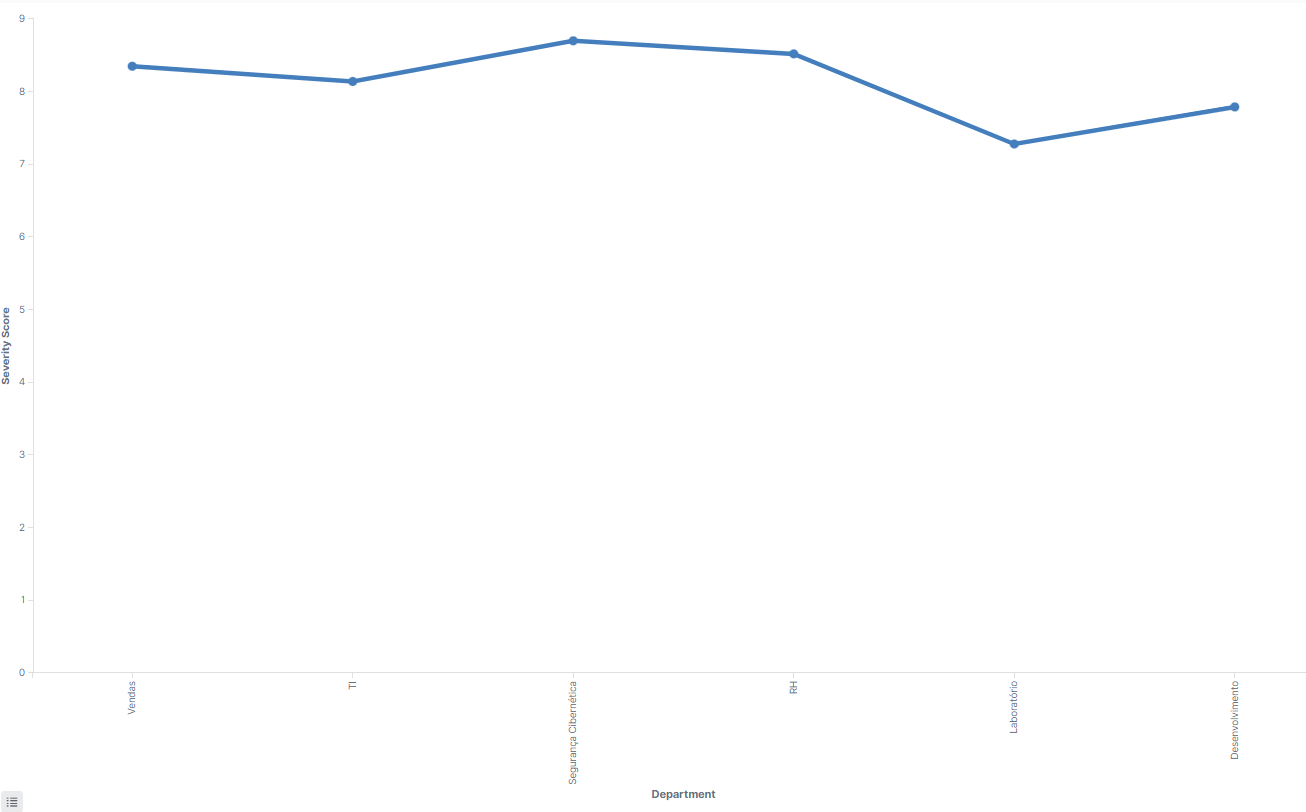

**Mediana de Severity Score**

A maior mediana foi a do departamento **Segurança Cibernética**(9.8) e a menor foi a do departamento **TI**(7.5)

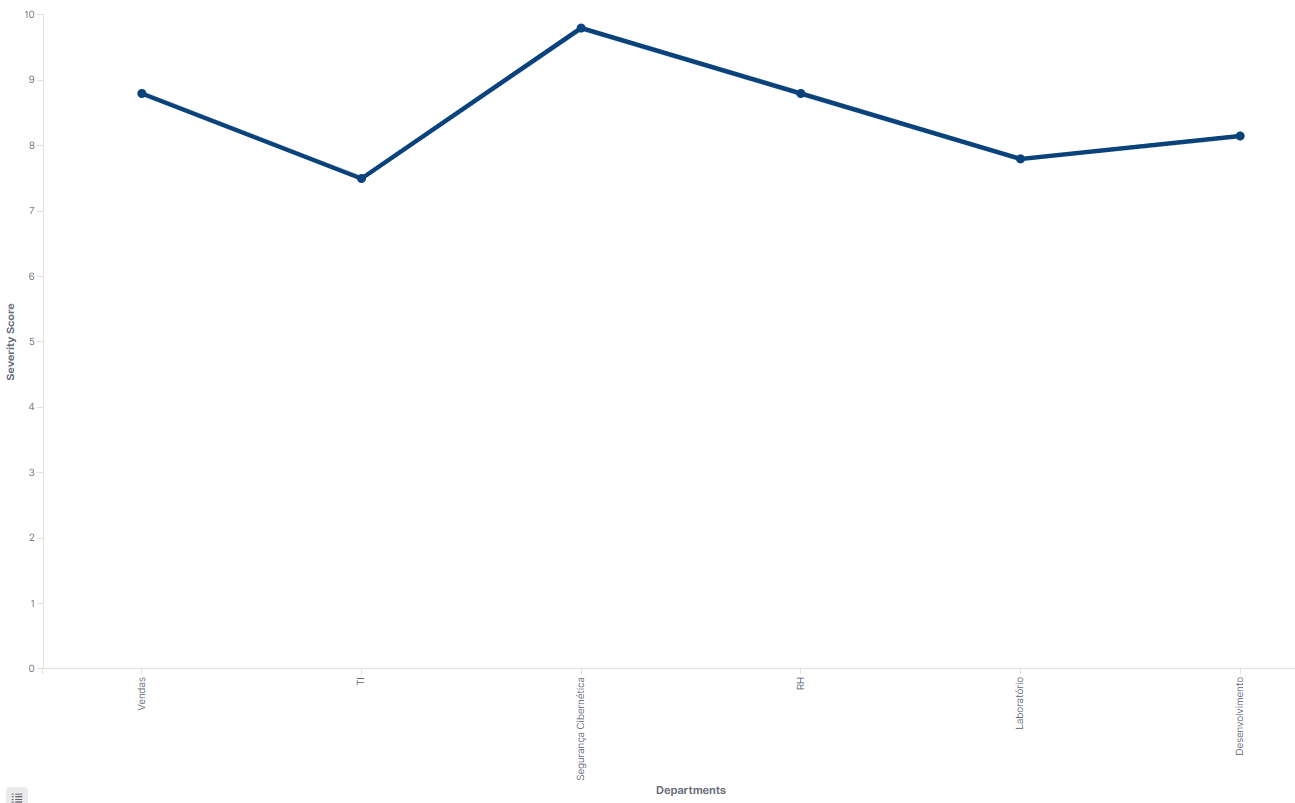

**Moda de Severity Score**

O departamento **Desenvolvimento** foi o que obteve a moda mais alta (10), enquanto a menor moda foi a do departamento TI(7.2). A métrica da Moda é talvez o mais importante neste contexto, pois indica tendências de repetições de vulnerabilidades de alta ou baixa criticidade nos ativos.

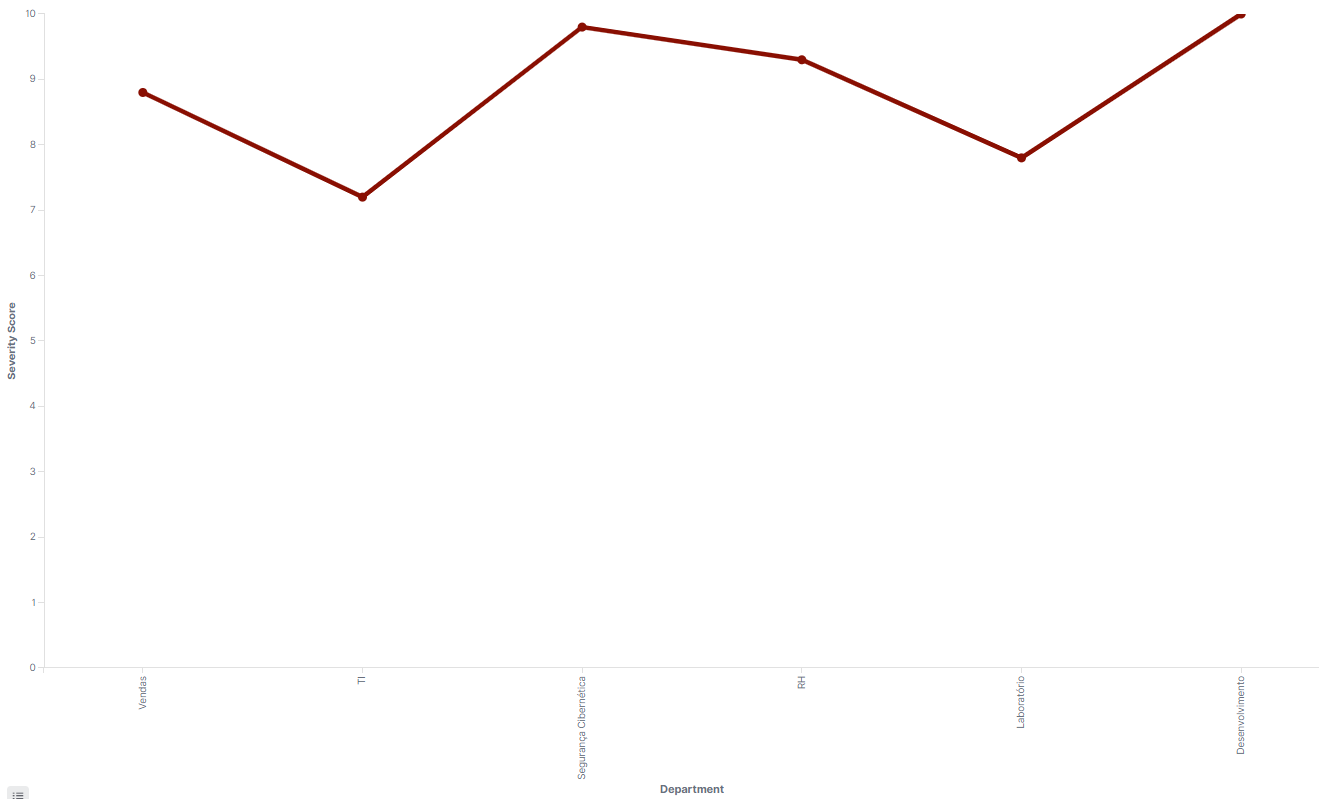

**Quantitativo de vulnerabilidades por setor**

É importante, na tomada de decisão, também ponderar a quantidade de vulnerabilidades encontradas para cada setor. O setor onde foram encontradas mais vulnerabilidades em ativos foi o de **Vendas**(437) e o que teve menor quantidade de vulnerabilidades foi o setor de Segurança Cibernética(8).


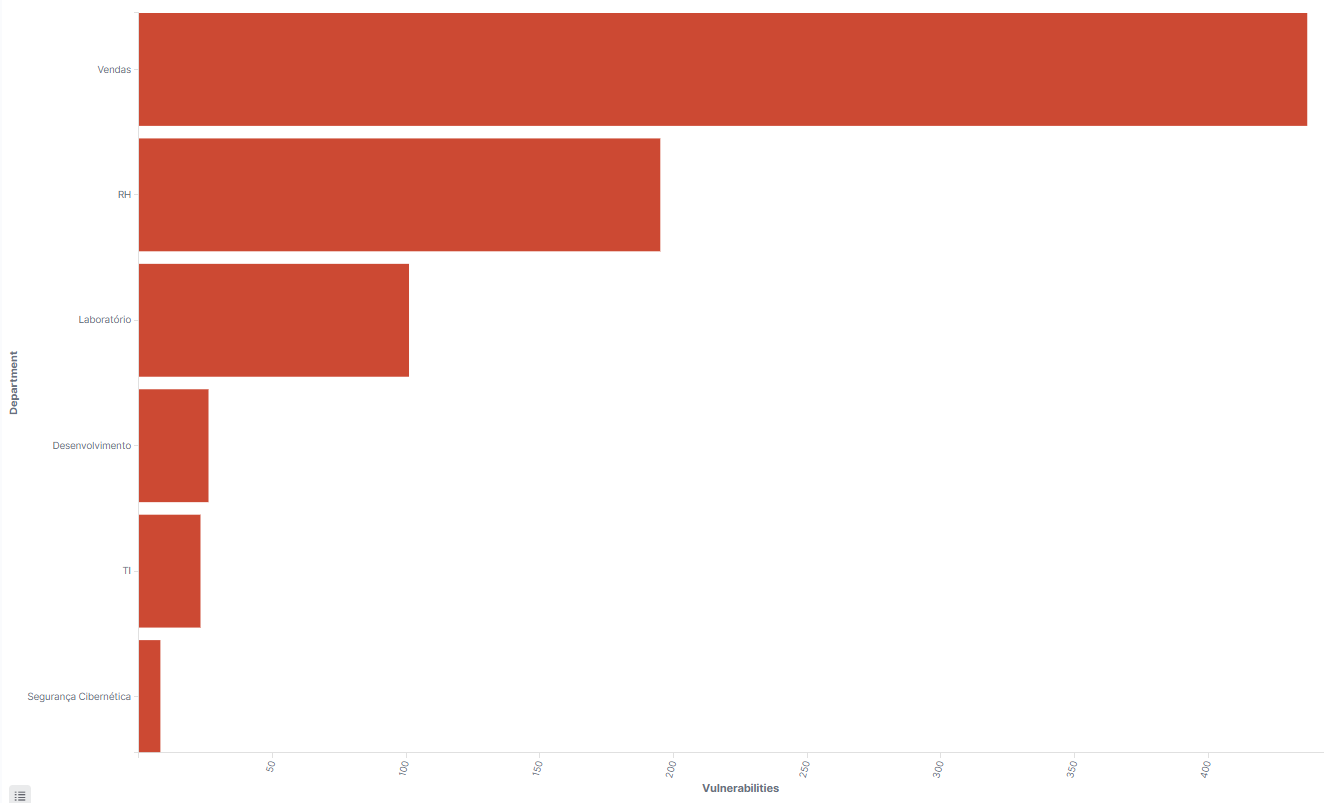

**Poporção de vulnerabilidades por Aplicação**

Com 44,86%, o Windows foi o sistema mais presente nos alertas de vulnerabilidades. Isso pode indicar uma necessidade de maior atenção às aplicações de patches de segurança e/ou medidas de mitigação.
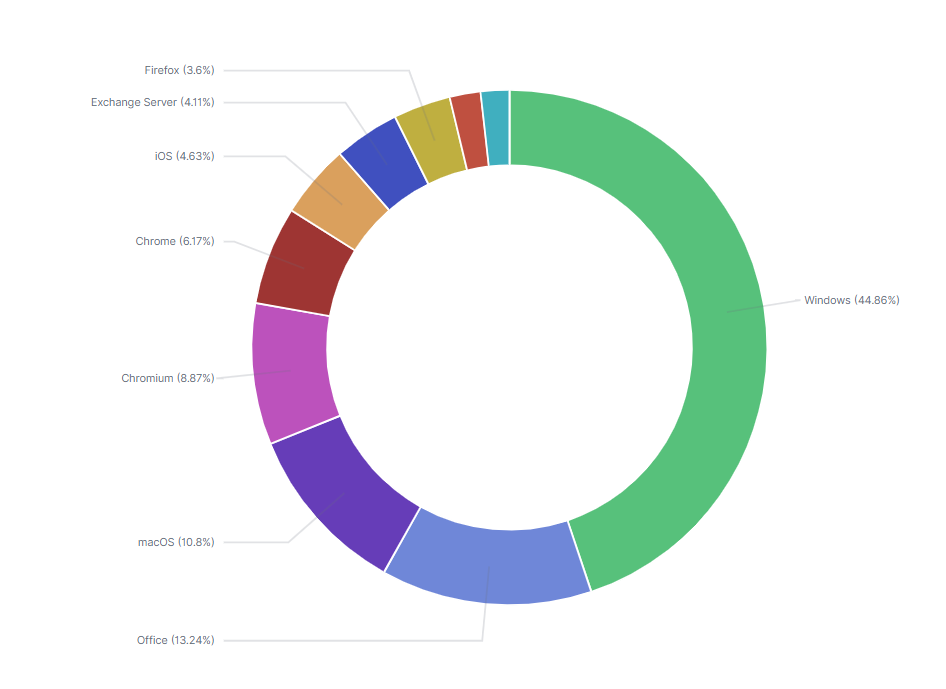

**Quantitativo de vulnerabilidaes por Host**

Com 144 CVEs encontradas, o host 'desktop4' foi indicado como o que possui mais alertas de vulnerabilidades.

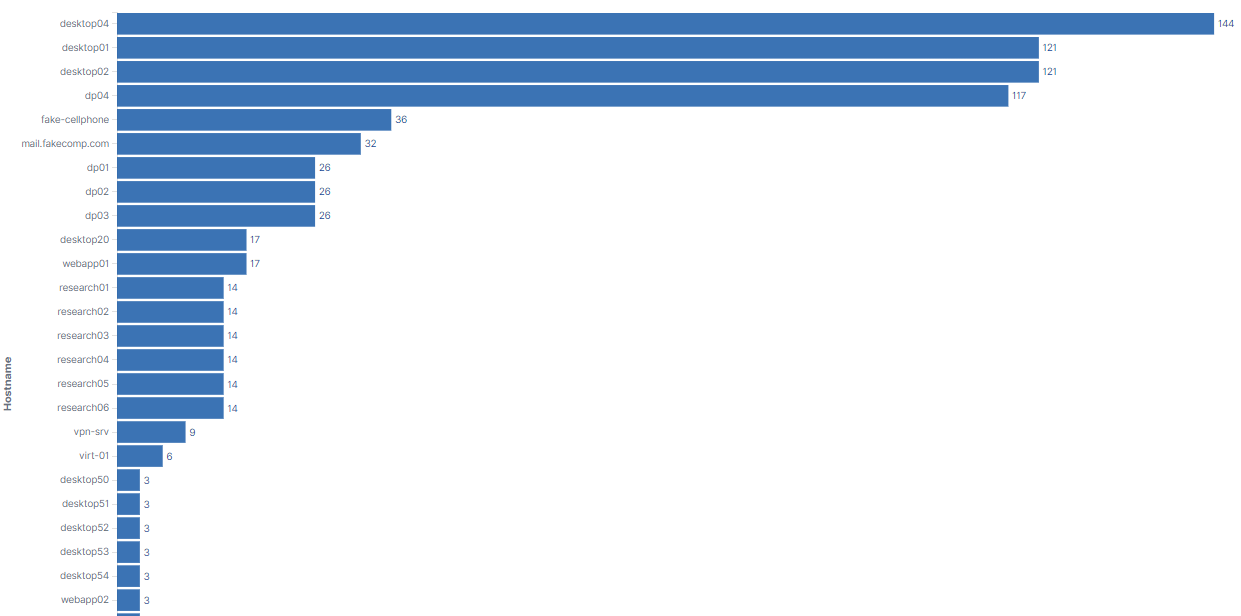

## **Pré-Processamento de dados**









### **Amostragem**


Usando a técnica de **amostragem estratificada**, foram separados: 

***Para teino:*** um subconjunto de 40 linhas de dados;

***Para teste:*** um subconjunto de 20 linhas de dados.

Lembrando que, para esta fase, é recomendado que o conjunto de treino seja maior que o conjunto de testes.

*Obs: As técnicas de amostragem serão utilizadas tanto no dataset cru, quanto no dataset discretizado.*

### **Conjunto de treino** (dataset original)

In [76]:
import json
import requests
import pandas as pd
import numpy as np
data=[]
#criando uma função com a estrutura de leitura de cada campo e dando append na lista 'data'
def es_doc_tr():
  alert_date = g['_source']['AlertDate']
  application = g['_source']['Application']
  department = g['_source']['Department']
  description = g['_source']['Description']
  exploitation_vector = g['_source']['ExploitationVector']
  hostname = g['_source']['Hostname']
  ip = g['_source']['IP']
  #é imprescindível que o campo severity score seja convertido em float
  severity_score = float(g['_source']['SeverityScore'])
  vendor = g['_source']['Vendor']
  vuln = g['_source']['Vulnerability']
  vuln_name = g['_source']['VulnerabilityName']
  #fazendo append de cada linha do dataset na lista 'data'
  data.append([vuln,  float(severity_score), vuln_name, alert_date, application, department, description, exploitation_vector, hostname, ip, vendor])
#query que retornará 40 registros, a partir do 21º, para garantir que não irá conflitar com o conjunto de teste
es_url = 'http://mvp-puc.brunoodon.com.br:9200/alerts/_search'
es_header = {'Content-Type': 'application/json'}
es_query_trainning = json.dumps({
    "from": 21,
    "size": 40,
    "query": {
        "match_all": {} 
  }})
labels = ['Vulnerability',  'SeverityScore', 'VulnerabilityName', 'AlertDate', 'Application', 'Department', 'Description', 'ExploitationVector', 'Hostname', 'IP', 'Vendor']
search_es_trainning = requests.post(es_url, headers=es_header, data=es_query_trainning)
result_es_trainning = json.loads(search_es_trainning.text)
#executando a função es_doc_tr para cada registro encontrado no índex do Elastic
for g in result_es_trainning['hits']['hits']:
  es_doc_tr()
#definindo e exibindo o dataset de treino  
df_trainning = pd.DataFrame(data, columns=labels)
display(df_trainning)



,Vulnerability,SeverityScore,VulnerabilityName,AlertDate,Application,Department,Description,ExploitationVector,Hostname,IP,Vendor
0,CVE-2022-41040,8.8,Microsoft Exchange Server Server-Side Request ...,2023-04-24,Exchange Server,TI,Microsoft Exchange Server allows for server-si...,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft
1,CVE-2021-34473,9.8,Microsoft Exchange Server Remote Code Executio...,2023-04-24,Exchange Server,TI,Microsoft Exchange Server Remote Code Executio...,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft
2,CVE-2021-34523,9.8,Microsoft Exchange Server Privilege Escalation...,2023-04-24,Exchange Server,TI,Microsoft Exchange Server Privilege Escalation...,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft
3,CVE-2021-33766,7.5,Microsoft Exchange Server Information Disclosure,2023-04-24,Exchange Server,TI,Microsoft Exchange Server contains an informat...,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:N/A:N,mail.fakecomp.com,172.16.0.20,Microsoft
4,CVE-2021-31207,7.2,Microsoft Exchange Server Security Feature Byp...,2023-04-24,Exchange Server,TI,Microsoft Exchange Server Security Feature Byp...,CVSS:3.1/AV:N/AC:L/PR:H/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft
5,CVE-2021-27065,7.8,Microsoft OWA Exchange Control Panel (ECP) Exp...,2023-04-24,Exchange Server,TI,Microsoft Exchange Server Remote Code Executio...,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft
6,CVE-2021-26858,7.8,Microsoft OWA Exchange Control Panel (ECP) Exp...,2023-04-24,Exchange Server,TI,Microsoft Exchange Server Remote Code Executio...,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft
7,CVE-2021-26857,7.8,Microsoft Unified Messaging Deserialization Vu...,2023-04-24,Exchange Server,TI,Microsoft Exchange Server Remote Code Executio...,CVSS:3.1/AV:L/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft
8,CVE-2021-26855,9.8,Microsoft OWA Exchange Control Panel (ECP) Exp...,2023-04-24,Exchange Server,TI,Microsoft Exchange Server Remote Code Executio...,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft
9,CVE-2020-17144,8.4,Microsoft Exchange Remote Code Execution Vulne...,2023-04-24,Exchange Server,TI,Microsoft Exchange Remote Code Execution Vulne...,CVSS:3.1/AV:N/AC:L/PR:H/UI:R/S:C/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft


### **Conjunto de teste** (dataset original)

In [77]:
#separando o dataset de teste com 20 linhas
data=[]
def es_doc_tst():
  alert_date = h['_source']['AlertDate']
  application = h['_source']['Application']
  department = h['_source']['Department']
  description = h['_source']['Description']
  exploitation_vector = h['_source']['ExploitationVector']
  hostname = h['_source']['Hostname']
  ip = h['_source']['IP']
  #transformando o campo severity_score em float
  severity_score = float(h['_source']['SeverityScore'])
  vendor = h['_source']['Vendor']
  vuln = h['_source']['Vulnerability']
  vuln_name = h['_source']['VulnerabilityName']
  data.append([vuln, severity_score, vuln_name, alert_date, application, department, description, exploitation_vector, hostname, ip, vendor])
es_query_testing = json.dumps({
    "from": 0,
    "size": 20,
    "query": {
        "match_all": {} 
}})
labels = ['Vulnerability',  'SeverityScore', 'VulnerabilityName', 'AlertDate', 'Application', 'Department', 'Description', 'ExploitationVector', 'Hostname', 'IP', 'Vendor']
search_es_testing = requests.post(es_url, headers=es_header, data=es_query_testing)
result_es_testing = json.loads(search_es_testing.text)
for h in result_es_testing['hits']['hits']:
  es_doc_tst()
df_testing = pd.DataFrame(data, columns=labels)
display(df_testing)

,Vulnerability,SeverityScore,VulnerabilityName,AlertDate,Application,Department,Description,ExploitationVector,Hostname,IP,Vendor
0,CVE-2022-41082,8.8,Microsoft Exchange Server Remote Code Executio...,2023-04-28,Exchange Server,TI,Microsoft Exchange Server contains an unspecif...,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft
1,CVE-2022-41082,8.8,Microsoft Exchange Server Remote Code Executio...,2023-04-28,Exchange Server,TI,Microsoft Exchange Server contains an unspecif...,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft
2,CVE-2022-41040,8.8,Microsoft Exchange Server Server-Side Request ...,2023-04-28,Exchange Server,TI,Microsoft Exchange Server allows for server-si...,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft
3,CVE-2021-34523,9.8,Microsoft Exchange Server Privilege Escalation...,2023-04-28,Exchange Server,TI,Microsoft Exchange Server Privilege Escalation...,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft
4,CVE-2021-34473,9.8,Microsoft Exchange Server Remote Code Executio...,2023-04-28,Exchange Server,TI,Microsoft Exchange Server Remote Code Executio...,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft
5,CVE-2021-33766,7.5,Microsoft Exchange Server Information Disclosure,2023-04-28,Exchange Server,TI,Microsoft Exchange Server contains an informat...,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:N/A:N,mail.fakecomp.com,172.16.0.20,Microsoft
6,CVE-2021-31207,7.2,Microsoft Exchange Server Security Feature Byp...,2023-04-28,Exchange Server,TI,Microsoft Exchange Server Security Feature Byp...,CVSS:3.1/AV:N/AC:L/PR:H/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft
7,CVE-2022-41082,8.8,Microsoft Exchange Server Remote Code Executio...,2023-04-24,Exchange Server,TI,Microsoft Exchange Server contains an unspecif...,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft
8,CVE-2022-41040,8.8,Microsoft Exchange Server Server-Side Request ...,2023-04-24,Exchange Server,TI,Microsoft Exchange Server allows for server-si...,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft
9,CVE-2021-34523,9.8,Microsoft Exchange Server Privilege Escalation...,2023-04-24,Exchange Server,TI,Microsoft Exchange Server Privilege Escalation...,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft


### **Transformação de dados**

Primeiramente, será utilizada a técnica de **discretização** para representar de forma literal a criticidade de cada alerta, tendo como base o SeverityScore de cada vulnerabilidade:

**LOW**:  > 0  e <= 5

**MEDIUM**:   > 5 e <= 7

**HIGH**:   > 7 e <= 9

**CRITICAL**:  > 9 e <= 10

Será adicionada uma última coluna chamada 'Risk' com as categorias acima.



In [78]:
#definindo os intervalos de severity scores:
intervals = [0, 5, 7, 9, 10]
#utilizando o pandas.cut para dividir os dados em categorias:
cat = pd.cut(df_all['SeverityScore'].to_numpy(), bins=intervals, labels=['LOW', 'MEDIUM', 'HIGH', 'CRITICAL'])
#atribuindo o label 'Risk' à coluna das categorias:
df_all['Risk'] = cat
#exibindo o dataset já com a coluna 'Risk':
display(df_all)
#exibindo a quantidade de vulnerabilidades para cada categoria de risco:
df_all['Risk'].value_counts()

,Vulnerability,SeverityScore,VulnerabilityName,AlertDate,Application,Department,Description,ExploitationVector,Hostname,IP,Vendor,Risk
0,CVE-2022-41082,8.8,Microsoft Exchange Server Remote Code Executio...,2023-04-28,Exchange Server,TI,Microsoft Exchange Server contains an unspecif...,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft,HIGH
1,CVE-2022-41082,8.8,Microsoft Exchange Server Remote Code Executio...,2023-04-28,Exchange Server,TI,Microsoft Exchange Server contains an unspecif...,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft,HIGH
2,CVE-2022-41040,8.8,Microsoft Exchange Server Server-Side Request ...,2023-04-28,Exchange Server,TI,Microsoft Exchange Server allows for server-si...,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft,HIGH
3,CVE-2021-34523,9.8,Microsoft Exchange Server Privilege Escalation...,2023-04-28,Exchange Server,TI,Microsoft Exchange Server Privilege Escalation...,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft,CRITICAL
4,CVE-2021-34473,9.8,Microsoft Exchange Server Remote Code Executio...,2023-04-28,Exchange Server,TI,Microsoft Exchange Server Remote Code Executio...,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft,CRITICAL
...,...,...,...,...,...,...,...,...,...,...,...,...
813,CVE-2022-41040,8.8,Microsoft Exchange Server Server-Side Request ...,2023-04-29,Exchange Server,TI,Microsoft Exchange Server allows for server-si...,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft,HIGH
814,CVE-2021-34523,9.8,Microsoft Exchange Server Privilege Escalation...,2023-04-29,Exchange Server,TI,Microsoft Exchange Server Privilege Escalation...,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft,CRITICAL
815,CVE-2021-34473,9.8,Microsoft Exchange Server Remote Code Executio...,2023-04-29,Exchange Server,TI,Microsoft Exchange Server Remote Code Executio...,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft,CRITICAL
816,CVE-2021-33766,7.5,Microsoft Exchange Server Information Disclosure,2023-04-29,Exchange Server,TI,Microsoft Exchange Server contains an informat...,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:N/A:N,mail.fakecomp.com,172.16.0.20,Microsoft,HIGH


HIGH        468
CRITICAL    216
MEDIUM      100
LOW          34
Name: Risk, dtype: int64

**Limpeza do dataset**

***Outliers***

O Severity Score de uma vulnerabilidade varia sempre de 0 a 10, sendo assim, vamos verificar a existência de valores acima de 10 no dataset, o que poderia indicar uma discrepância:



In [79]:
from pandas._libs.hashtable import value_count
outliers = df_all.where(df_all['SeverityScore'] > 10)
outliers_count = outliers.value_counts()

Percebe-se, portanto, que não existem outliers no dataset

***Redundâncias***

Removendo as linhas idênticas do dataset para garantir que não existam registros repetidos.

In [80]:
#removendo linhas duplicadas do dataset
df_clear = df_all.drop_duplicates()
#salvando o dataset limpo em formato CSV:
df_clear.to_csv('vulnerability_alerts_clear.csv', index=False)
pd.read_csv('vulnerability_alerts_clear.csv')

,Vulnerability,SeverityScore,VulnerabilityName,AlertDate,Application,Department,Description,ExploitationVector,Hostname,IP,Vendor,Risk
0,CVE-2022-41082,8.8,Microsoft Exchange Server Remote Code Executio...,2023-04-28,Exchange Server,TI,Microsoft Exchange Server contains an unspecif...,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft,HIGH
1,CVE-2022-41040,8.8,Microsoft Exchange Server Server-Side Request ...,2023-04-28,Exchange Server,TI,Microsoft Exchange Server allows for server-si...,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft,HIGH
2,CVE-2021-34523,9.8,Microsoft Exchange Server Privilege Escalation...,2023-04-28,Exchange Server,TI,Microsoft Exchange Server Privilege Escalation...,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft,CRITICAL
3,CVE-2021-34473,9.8,Microsoft Exchange Server Remote Code Executio...,2023-04-28,Exchange Server,TI,Microsoft Exchange Server Remote Code Executio...,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft,CRITICAL
4,CVE-2021-33766,7.5,Microsoft Exchange Server Information Disclosure,2023-04-28,Exchange Server,TI,Microsoft Exchange Server contains an informat...,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:N/A:N,mail.fakecomp.com,172.16.0.20,Microsoft,HIGH
...,...,...,...,...,...,...,...,...,...,...,...,...
795,CVE-2022-41040,8.8,Microsoft Exchange Server Server-Side Request ...,2023-04-29,Exchange Server,TI,Microsoft Exchange Server allows for server-si...,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft,HIGH
796,CVE-2021-34523,9.8,Microsoft Exchange Server Privilege Escalation...,2023-04-29,Exchange Server,TI,Microsoft Exchange Server Privilege Escalation...,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft,CRITICAL
797,CVE-2021-34473,9.8,Microsoft Exchange Server Remote Code Executio...,2023-04-29,Exchange Server,TI,Microsoft Exchange Server Remote Code Executio...,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft,CRITICAL
798,CVE-2021-33766,7.5,Microsoft Exchange Server Information Disclosure,2023-04-29,Exchange Server,TI,Microsoft Exchange Server contains an informat...,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:N/A:N,mail.fakecomp.com,172.16.0.20,Microsoft,HIGH


***Missings***

Verificando, pela métrica da soma dos registos vazios, se existem valores faltantes no dataset

In [81]:
print(df_all.isnull().sum())

Vulnerability         0
SeverityScore         0
VulnerabilityName     0
AlertDate             0
Application           0
Department            0
Description           0
ExploitationVector    0
Hostname              0
IP                    0
Vendor                0
Risk                  0
dtype: int64


Conclui-se que também não existem missings neste dataset.

**Normalizando os dados do campo SeverityScore**

In [82]:
import numpy as np
#separando os dados e normalizando
data = [df_all['SeverityScore']]
max_data = np.max(data)
min_data = np.min(data)
norm_data = (data - min_data) / (max_data - min_data)
#convertendo de array para lista, para que os dados sobrescrevam os dados da coluna SeverityScore
array = norm_data.tolist()
for data_norm in array:
  df_all['SeverityScore'] = data_norm
#salvando e lendo o dataset normalizado
df_all.to_csv('vulnerability_alerts_norm.csv', index=False)
pd.read_csv('vulnerability_alerts_norm.csv')

,Vulnerability,SeverityScore,VulnerabilityName,AlertDate,Application,Department,Description,ExploitationVector,Hostname,IP,Vendor,Risk
0,CVE-2022-41082,0.851852,Microsoft Exchange Server Remote Code Executio...,2023-04-28,Exchange Server,TI,Microsoft Exchange Server contains an unspecif...,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft,HIGH
1,CVE-2022-41082,0.851852,Microsoft Exchange Server Remote Code Executio...,2023-04-28,Exchange Server,TI,Microsoft Exchange Server contains an unspecif...,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft,HIGH
2,CVE-2022-41040,0.851852,Microsoft Exchange Server Server-Side Request ...,2023-04-28,Exchange Server,TI,Microsoft Exchange Server allows for server-si...,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft,HIGH
3,CVE-2021-34523,0.975309,Microsoft Exchange Server Privilege Escalation...,2023-04-28,Exchange Server,TI,Microsoft Exchange Server Privilege Escalation...,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft,CRITICAL
4,CVE-2021-34473,0.975309,Microsoft Exchange Server Remote Code Executio...,2023-04-28,Exchange Server,TI,Microsoft Exchange Server Remote Code Executio...,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft,CRITICAL
...,...,...,...,...,...,...,...,...,...,...,...,...
813,CVE-2022-41040,0.851852,Microsoft Exchange Server Server-Side Request ...,2023-04-29,Exchange Server,TI,Microsoft Exchange Server allows for server-si...,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft,HIGH
814,CVE-2021-34523,0.975309,Microsoft Exchange Server Privilege Escalation...,2023-04-29,Exchange Server,TI,Microsoft Exchange Server Privilege Escalation...,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft,CRITICAL
815,CVE-2021-34473,0.975309,Microsoft Exchange Server Remote Code Executio...,2023-04-29,Exchange Server,TI,Microsoft Exchange Server Remote Code Executio...,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft,CRITICAL
816,CVE-2021-33766,0.691358,Microsoft Exchange Server Information Disclosure,2023-04-29,Exchange Server,TI,Microsoft Exchange Server contains an informat...,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:N/A:N,mail.fakecomp.com,172.16.0.20,Microsoft,HIGH


**Padronizando os dados do campo SeverityScore**

In [83]:
import numpy as np
#separando os dados e padronizando
data = [df_all['SeverityScore']]
average = np.mean(data)
std_deviation = np.std(data)
std_data = (data - average) / (std_deviation)
#convertendo de array para lista, para que os dados sobrescrevam os dados da coluna SeverityScore
array = std_data.tolist()
for data_std in array:
  df_all['SeverityScore'] = data_std
# exibindo o dataset padronizado
display(df_all)

,Vulnerability,SeverityScore,VulnerabilityName,AlertDate,Application,Department,Description,ExploitationVector,Hostname,IP,Vendor,Risk
0,CVE-2022-41082,0.579595,Microsoft Exchange Server Remote Code Executio...,2023-04-28,Exchange Server,TI,Microsoft Exchange Server contains an unspecif...,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft,HIGH
1,CVE-2022-41082,0.579595,Microsoft Exchange Server Remote Code Executio...,2023-04-28,Exchange Server,TI,Microsoft Exchange Server contains an unspecif...,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft,HIGH
2,CVE-2022-41040,0.579595,Microsoft Exchange Server Server-Side Request ...,2023-04-28,Exchange Server,TI,Microsoft Exchange Server allows for server-si...,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft,HIGH
3,CVE-2021-34523,1.305642,Microsoft Exchange Server Privilege Escalation...,2023-04-28,Exchange Server,TI,Microsoft Exchange Server Privilege Escalation...,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft,CRITICAL
4,CVE-2021-34473,1.305642,Microsoft Exchange Server Remote Code Executio...,2023-04-28,Exchange Server,TI,Microsoft Exchange Server Remote Code Executio...,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft,CRITICAL
...,...,...,...,...,...,...,...,...,...,...,...,...
813,CVE-2022-41040,0.579595,Microsoft Exchange Server Server-Side Request ...,2023-04-29,Exchange Server,TI,Microsoft Exchange Server allows for server-si...,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft,HIGH
814,CVE-2021-34523,1.305642,Microsoft Exchange Server Privilege Escalation...,2023-04-29,Exchange Server,TI,Microsoft Exchange Server Privilege Escalation...,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft,CRITICAL
815,CVE-2021-34473,1.305642,Microsoft Exchange Server Remote Code Executio...,2023-04-29,Exchange Server,TI,Microsoft Exchange Server Remote Code Executio...,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft,CRITICAL
816,CVE-2021-33766,-0.364266,Microsoft Exchange Server Information Disclosure,2023-04-29,Exchange Server,TI,Microsoft Exchange Server contains an informat...,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:N/A:N,mail.fakecomp.com,172.16.0.20,Microsoft,HIGH


Nota: observa-se que o resultado da padronização trouxe alguns severity scores negativos, o que não faz sentido, pois o indicador é necessariamente um número positivo de 0 a 10. Sendo assim, não foi salvo nenhum dataset padronizado, pois o método escolhido de ajuste de escala foi o da **normalização**.

### **Conjunto de treino do dataset normalizado**

Separando as 40 primeiras linhas do dataset normalizado para treino e salvando em formato csv.

In [84]:
df_norm_tr = pd.read_csv('vulnerability_alerts_norm.csv').head(40)
df_norm_tr.to_csv('vulnerability_alerts_norm_tr.csv', index=False)
display(df_norm_tr)


,Vulnerability,SeverityScore,VulnerabilityName,AlertDate,Application,Department,Description,ExploitationVector,Hostname,IP,Vendor,Risk
0,CVE-2022-41082,0.851852,Microsoft Exchange Server Remote Code Executio...,2023-04-28,Exchange Server,TI,Microsoft Exchange Server contains an unspecif...,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft,HIGH
1,CVE-2022-41082,0.851852,Microsoft Exchange Server Remote Code Executio...,2023-04-28,Exchange Server,TI,Microsoft Exchange Server contains an unspecif...,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft,HIGH
2,CVE-2022-41040,0.851852,Microsoft Exchange Server Server-Side Request ...,2023-04-28,Exchange Server,TI,Microsoft Exchange Server allows for server-si...,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft,HIGH
3,CVE-2021-34523,0.975309,Microsoft Exchange Server Privilege Escalation...,2023-04-28,Exchange Server,TI,Microsoft Exchange Server Privilege Escalation...,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft,CRITICAL
4,CVE-2021-34473,0.975309,Microsoft Exchange Server Remote Code Executio...,2023-04-28,Exchange Server,TI,Microsoft Exchange Server Remote Code Executio...,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft,CRITICAL
5,CVE-2021-33766,0.691358,Microsoft Exchange Server Information Disclosure,2023-04-28,Exchange Server,TI,Microsoft Exchange Server contains an informat...,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:N/A:N,mail.fakecomp.com,172.16.0.20,Microsoft,HIGH
6,CVE-2021-31207,0.654321,Microsoft Exchange Server Security Feature Byp...,2023-04-28,Exchange Server,TI,Microsoft Exchange Server Security Feature Byp...,CVSS:3.1/AV:N/AC:L/PR:H/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft,HIGH
7,CVE-2022-41082,0.851852,Microsoft Exchange Server Remote Code Executio...,2023-04-24,Exchange Server,TI,Microsoft Exchange Server contains an unspecif...,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft,HIGH
8,CVE-2022-41040,0.851852,Microsoft Exchange Server Server-Side Request ...,2023-04-24,Exchange Server,TI,Microsoft Exchange Server allows for server-si...,CVSS:3.1/AV:N/AC:L/PR:L/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft,HIGH
9,CVE-2021-34523,0.975309,Microsoft Exchange Server Privilege Escalation...,2023-04-24,Exchange Server,TI,Microsoft Exchange Server Privilege Escalation...,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,mail.fakecomp.com,172.16.0.20,Microsoft,CRITICAL


### **Conjunto de teste do dataset normalizado**

Separando as 20 últimas linhas do dataset normalizado para teste e salvando em formato csv.

In [85]:
df_norm_tst = pd.read_csv('vulnerability_alerts_norm.csv').tail(20)
df_norm_tst.to_csv('vulnerability_alerts_norm_tst.csv', index=False)
display(df_norm_tst)

,Vulnerability,SeverityScore,VulnerabilityName,AlertDate,Application,Department,Description,ExploitationVector,Hostname,IP,Vendor,Risk
798,CVE-2017-0005,0.617284,Microsoft Windows Graphics Device Interface (G...,2023-04-24,Windows,RH,The Graphics Device Interface (GDI) in Microso...,AV:L/AC:M/Au:N/C:C/I:C/A:C,dp04,192.168.7.34,Microsoft,MEDIUM
799,CVE-2016-7256,0.913580,Microsoft Windows Open Type Font Remote Code E...,2023-04-24,Windows,RH,A remote code execution vulnerability exists w...,AV:N/AC:M/Au:N/C:C/I:C/A:C,dp04,192.168.7.34,Microsoft,CRITICAL
800,CVE-2016-7255,0.654321,"Microsoft Windows Vista, 7, 8.1, 10 and Window...",2023-04-24,Windows,RH,The kernel-mode drivers allow local users to g...,AV:L/AC:L/Au:N/C:C/I:C/A:C,dp04,192.168.7.34,Microsoft,HIGH
801,CVE-2016-3393,0.913580,Microsoft Windows Graphics Device Interface (G...,2023-04-24,Windows,RH,A remote code execution vulnerability exists d...,AV:N/AC:M/Au:N/C:C/I:C/A:C,dp04,192.168.7.34,Microsoft,CRITICAL
802,CVE-2016-3309,0.654321,Microsoft Windows Kernel Privilege Escalation ...,2023-04-24,Windows,RH,A privilege escalation vulnerability exists wh...,AV:L/AC:L/Au:N/C:C/I:C/A:C,dp04,192.168.7.34,Microsoft,HIGH
803,CVE-2016-0185,0.913580,Microsoft Windows Media Center Remote Code Exe...,2023-04-24,Windows,RH,Media Center allows remote attackers to execut...,AV:N/AC:M/Au:N/C:C/I:C/A:C,dp04,192.168.7.34,Microsoft,CRITICAL
804,CVE-2016-0167,0.654321,Microsoft Windows Kernel 'Win32k.sys' Local Pr...,2023-04-24,Windows,RH,The kernel-mode driver allows local users to g...,AV:L/AC:L/Au:N/C:C/I:C/A:C,dp04,192.168.7.34,Microsoft,HIGH
805,CVE-2016-0099,0.654321,Microsoft Windows Secondary Logon Service Priv...,2023-04-24,Windows,RH,A privilege escalation vulnerability exists in...,AV:L/AC:L/Au:N/C:C/I:C/A:C,dp04,192.168.7.34,Microsoft,HIGH
806,CVE-2016-0040,0.654321,Microsoft Windows Kernel Privilege Escalation ...,2023-04-24,Windows,RH,The kernel in Microsoft Windows allows local u...,AV:L/AC:L/Au:N/C:C/I:C/A:C,dp04,192.168.7.34,Microsoft,HIGH
807,CVE-2015-6175,0.654321,Microsoft Windows Kernel Privilege Escalation ...,2023-04-24,Windows,RH,The kernel in Microsoft Windows contains a vul...,AV:L/AC:L/Au:N/C:C/I:C/A:C,dp04,192.168.7.34,Microsoft,HIGH
